<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Проект: «Определение возраста покупателей»

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель:**
1. Построить модель, которая по фотографии определит возраст человека.
2. Получить значение метрики MAE менее 8.

В вашем распоряжении набор фотографий людей с указанием возраста. Данные взяты с сайта *ChaLearn Looking at People*.

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_seed = 42
%matplotlib inline
sns.set_style("darkgrid")

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_get_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                   directory='/datasets/faces/final_files/',
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='raw',
                                                   seed=random_seed)

Found 7591 validated image filenames.


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [3]:
print(f'В исследуемой выборке {labels.shape[0]} изображение')

В исследуемой выборке 7591 изображение


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


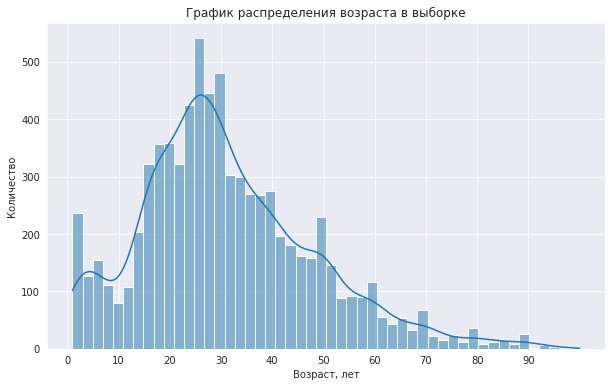

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.histplot(labels['real_age'], kde=True, bins=50)
ax.set_title('График распределения возраста в выборке', fontsize=12)
ax.set_xlabel('Возраст, лет', fontsize=10)
ax.set_ylabel('Количество', fontsize=10)
plt.xticks(range(0, 100, 10));

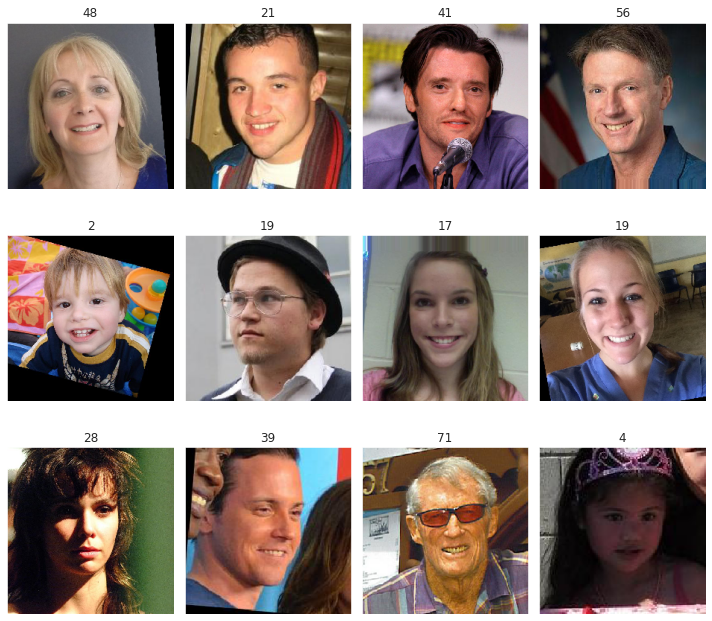

In [8]:
features, age = next(train_get_flow)

fig = plt.figure(figsize=(10, 10))

for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.title(age[i])
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Выводы:**
1. Исследуемая выборка состоит из 7591 объекта.
2. Значения возраста объектов распределены в диапазоне от 1 до 100 лет со средним значением 31.2 года и со стандартным отклонением в 17.1 года.
3. 75 % объектов на изображениях имеют возраст до 41 года, что в итоге может отразиться на качестве определения возраста пожилых людей, ввиду их недостаточного присутствия в выборке и недостаточным обобщением моделью данной категории объектов.

## Обучение модели

Для достижения поставленной цели используем сверточную нейронную сеть *ResNet50*, предобученную на датасете `imagenet`. Для тестовой выборки будет выделено 25 % изображений.

Код в этом разделе запускается на отдельном GPU-сервере

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd
random_seed = 42


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255
                                 )
    datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                               directory=path + 'final_files/',
                                               x_col='file_name',
                                               y_col='real_age',
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='raw',
                                               subset='training',
                                               seed=random_seed)                                          
        
    return datagen_flow
    
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255)
    datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                               directory=path + 'final_files/',
                                               x_col='file_name',
                                               y_col='real_age',
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='raw',
                                               subset='validation',
                                               seed=random_seed)                                          
        
    return datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    
    optimizer = Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=0, epochs=20,
                steps_per_epoch=None, validation_steps=None): 
    if steps_per_epoch is None:
        steps_per_epoch=len(train_data)
    
    if validation_steps is None:
        validation_steps=len(test_data)
        
    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```
Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 104s - loss: 245.1657 - mae: 11.2038 - val_loss: 1016.3218 - val_mae: 27.0819
Epoch 2/20
178/178 - 38s - loss: 61.7152 - mae: 5.9917 - val_loss: 965.1588 - val_mae: 26.1843
Epoch 3/20
178/178 - 37s - loss: 32.2635 - mae: 4.3541 - val_loss: 307.6470 - val_mae: 12.9404
Epoch 4/20
178/178 - 38s - loss: 20.8477 - mae: 3.5442 - val_loss: 133.6294 - val_mae: 8.6312
Epoch 5/20
178/178 - 38s - loss: 15.2909 - mae: 3.0234 - val_loss: 103.9007 - val_mae: 7.7300
Epoch 6/20
178/178 - 38s - loss: 12.5043 - mae: 2.7011 - val_loss: 97.5994 - val_mae: 7.9127
Epoch 7/20
178/178 - 38s - loss: 9.9948 - mae: 2.4118 - val_loss: 69.1582 - val_mae: 6.3277
Epoch 8/20
178/178 - 38s - loss: 9.4581 - mae: 2.3539 - val_loss: 75.3735 - val_mae: 6.4525
Epoch 9/20
178/178 - 38s - loss: 8.7760 - mae: 2.2594 - val_loss: 79.0226 - val_mae: 6.6796
Epoch 10/20
178/178 - 38s - loss: 7.8769 - mae: 2.1205 - val_loss: 65.0601 - val_mae: 5.9984
Epoch 11/20
178/178 - 38s - loss: 7.3943 - mae: 2.0439 - val_loss: 67.3080 - val_mae: 6.2562
Epoch 12/20
178/178 - 38s - loss: 7.0006 - mae: 1.9752 - val_loss: 79.2051 - val_mae: 6.5282
Epoch 13/20
178/178 - 38s - loss: 6.3405 - mae: 1.8816 - val_loss: 64.7428 - val_mae: 6.1263
Epoch 14/20
178/178 - 38s - loss: 5.5030 - mae: 1.7524 - val_loss: 69.2412 - val_mae: 6.2321
Epoch 15/20
178/178 - 38s - loss: 4.8000 - mae: 1.6458 - val_loss: 75.3831 - val_mae: 6.7796
Epoch 16/20
178/178 - 38s - loss: 4.6280 - mae: 1.6286 - val_loss: 65.9020 - val_mae: 6.1245
Epoch 17/20
178/178 - 38s - loss: 4.9735 - mae: 1.6783 - val_loss: 66.1559 - val_mae: 6.0648
Epoch 18/20
178/178 - 38s - loss: 5.0419 - mae: 1.6816 - val_loss: 72.0068 - val_mae: 6.2139
Epoch 19/20
178/178 - 38s - loss: 5.3226 - mae: 1.7434 - val_loss: 85.1498 - val_mae: 6.8846
Epoch 20/20
178/178 - 38s - loss: 5.6989 - mae: 1.8289 - val_loss: 65.6195 - val_mae: 6.1388
60/60 - 9s - loss: 65.6195 - mae: 6.1388
Test MAE: 6.1388
```

## Анализ обученной модели

- Архитектура — ResNet50;
- Функция потерь — MSE;
- Алгоритм оптимизации — Adam (learning rate = 1e-4);
- Количество эпох — 20;
- Augmentation — False;

Предобученная на датасете `imagenet` CNN ResNet50 показала итоговое MAE на тестовой выборке 6.1388 лет в течение 20 эпох обучения. В статье о датасете, с которым мы работаем, значение MAE равно 5.4.

## Общий вывод

Перед нами стояла цель построить нейронную сеть для задачи компьютерного зрения, которая по фотографии определит возраст человека. В дальнейшем модель будет использоваться сетевым супермаркетом, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, а также контролировать добросовестность кассиров при продаже алкоголя.

Исследуемая выборка состояла из *7591* объекта. Данные были взяты с сайта `ChaLearn Looking at People`. Значения возраста объектов в исследуемой выборке распределены в диапазоне от *1* до *100* лет со средним значением *31.2* года и со стандартным отклонением в *17.1* года.

Для достижения поставленной цели использовали сверточную нейронную сеть ResNet50, предобученную на датасете `imagenet`. Для тестовой выборки было выделено *25 %* изображений. Аугментация данных не проводилась.

В качестве метрики оценки производительности использовалась метрика MAE.

В результате проведенного исследования, предобученная на датасете `imagenet` CNN ResNet50 показала итоговое MAE на тестовой выборке *6.1388* лет в течение *20* эпох обучения.

С учетом полученных результатов **рекомендуется** использовать данную модель для выполнения первой поставленной задачи — анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы при предварительной категоризации потенциальных покупателей на следующие возрастные категории:
- дети;
- юноши;
- молодые люди;
- покупатели среднего возраста;
- пожилые.

Что касается второй задачи — контролировать добросовестность кассиров при продаже алкоголя — с учетом MAE в *6.1* года, модель не покажет хороших результатов на практике.